# Problem Statement

In [1]:
#Dengue fever remains a significant public health concern in the Philippines, with outbreaks occurring annually
#and widespread transmission across various regions (Alcala & Varela, 2020). Despite ongoing efforts to control
#the disease, the persistence of dengue cases, especially in specific hotspot areas, continues to challenge public
#health management and response strategies (DOH, 2021). The geographical distribution of dengue cases is influenced
#by various factors, including weather conditions, sanitation, and water supply (Zhang & Chen, 2019). However, a
#comprehensive understanding of how these factors interact in different regions is lacking (Edillo & Santos, 2021).
#This study aims to map dengue hotspots in the Philippines and analyze the correlation between environmental factors,
#such as temperature, sanitation, and water supply, with the spread of dengue. By identifying high-risk areas and
#understanding the underlying drivers of disease transmission, the study seeks to provide actionable insights for
#improving public health preparedness, raising awareness, and enhancing prevention measures across the country (WHO, 2022).


# GeoPandas Mapping

In [2]:
#Import important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import geopandas as gpd
import folium
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets
from ipywidgets import interact
import seaborn as sns
import warnings
import matplotlib.colors as mcolors
warnings.filterwarnings('ignore')

In [3]:
#Data Sets (placed in gitHub for easy loading)
gdfPh = gpd.read_file("https://raw.githubusercontent.com/renatomaaliw3/public_files/master/Data%20Sets/GeoData/gadm41_PHL_1.json")
gdfphRegion = pd.read_csv('https://raw.githubusercontent.com/ixahh/CPE15-Cognate-Professional-Course-1/refs/heads/main/DataSets/PH-REGION-GPD.csv')
gdfphProvince = pd.read_csv('https://raw.githubusercontent.com/ixahh/CPE15-Cognate-Professional-Course-1/refs/heads/main/DataSets/PH-PROVINCE-GPD.csv')
gdfdengData = pd.read_csv('https://raw.githubusercontent.com/ixahh/CPE15-Cognate-Professional-Course-1/refs/heads/main/Data%20Sets/Data-Sets-Dengue-Sanitation-WaterSupply.csv')
totalCases = pd.read_csv('https://raw.githubusercontent.com/ixahh/CPE15-Cognate-Professional-Course-1/refs/heads/main/DataSets/TotalDengueCasesPerRegion.csv')
townCases = pd.read_csv('https://raw.githubusercontent.com/ixahh/CPE15-Cognate-Professional-Course-1/refs/heads/main/DataSets/DengueCases16-21.csv')
tempYear = pd.read_csv('https://raw.githubusercontent.com/ixahh/CPE15-Cognate-Professional-Course-1/refs/heads/main/DataSets/observed-annual-average.csv')
tempMonth = pd.read_csv('https://raw.githubusercontent.com/ixahh/CPE15-Cognate-Professional-Course-1/refs/heads/main/DataSets/chart.csv')

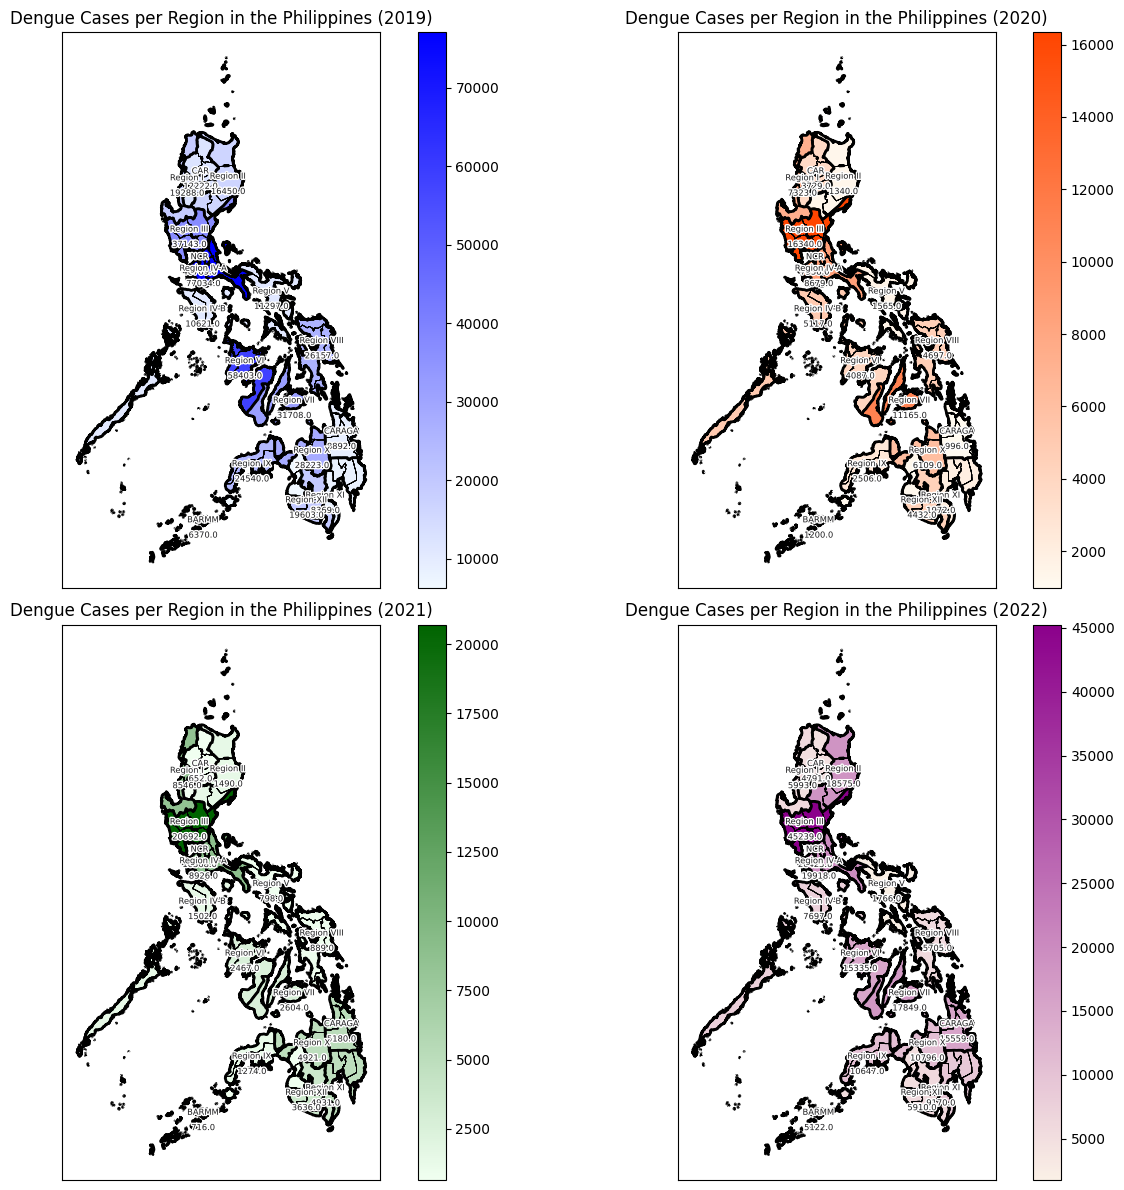

In [4]:
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns

# Define a dictionary mapping region codes to region names
regionName = {
    1: 'Region I',
    2: 'Region II',
    3: 'Region III',
    4: 'Region IV-A',
    5: 'Region V',
    6: 'Region VI',
    7: 'Region VII',
    8: 'Region VIII',
    9: 'Region IX',
    10: 'Region X',
    11: 'Region XI',
    12: 'Region XII',
    13: 'NCR',
    14: 'CAR',
    15: 'BARMM',
    16: 'CARAGA',
    17: 'Region IV-B'
}

# Define a dictionary mapping region names to region codes
regionCode = {
  'I' : 1,
  'II' : 2,
  'III' : 3,
  'IV-A' : 4,
  'V' : 5,
  'VI' : 6,
  'VII': 7,
  'VIII': 8,
  'IX' : 9,
  'X': 10,
  'XI': 11,
  'XII': 12,
  'NCR': 13,
  'CAR' : 14,
  'BARMM': 15,
  'XIII': 16,
 'MIMAROPA' : 17
}

# Define a dictionary mapping region codes to specific colors for visualization
regionColors = {
    1: '#FFCCCB',
    2: '#FF7F50',
    3: '#FF6347',
    4: '#FF4500',
    5: '#FF8C00',
    6: '#FFA500',
    7: '#FFD700',
    8: '#FFFF00',
    9: '#F0E68C',
    10: '#FFFACD',
    11: '#F4A460',
    12: '#D2691E',
    13: '#B22222',
    14: '#DC143C',
    15: '#FF1493',
    16: '#FF4500',
    17: '#FF6347'
}

# Merge the region and province dataframes based on the 'regCode' column
x = gdfphRegion.merge(gdfphProvince, on='regCode', how = 'inner')

# Rename 'provDesc' column to 'NAME_1' for consistency across datasets
x = x.rename(columns = {'provDesc' : 'NAME_1'})

# Merge the geographical data with the province-region data
gpdPhFinal = gdfPh.merge(x, on = 'NAME_1', how = 'inner')

# Map 'RegCode' in the dengue data to corresponding region codes
gdfdengData['RegCode'] = gdfdengData['RegCode'].map(regionCode)

# Rename 'RegCode' column to 'regCode' for consistency with other dataframes
gdfdengData = gdfdengData.rename(columns = {'RegCode' : 'regCode'})

# Ensure 'regCode' in the geographical data is of integer type for accurate merging
gpdPhFinal['regCode'] = gpdPhFinal['regCode'].astype(int)


# Merge the dengue data with the geographical data based on 'regCode'
gpdPhFinal = gpdPhFinal.merge(gdfdengData, on = 'regCode', how = 'inner')

# Map region codes in the merged data to region names for easier identification
gpdPhFinal['Region'] = gpdPhFinal['regCode'].map(regionName)

# Drop unnecessary columns from the data to clean it up
phdataSorted = gpdPhFinal.drop(['GID_1', 'GID_0', 'VARNAME_1',
                                    'NL_NAME_1', 'TYPE_1', 'ENGTYPE_1',
                                    'CC_1', 'HASC_1', 'id_x',
                                    'psgcCode_x', 'regDesc',
                                    'Unnamed: 4', 'id_y', 'psgcCode_y',
                                    'provCode'], axis = 1)

# Further clean the data by removing columns related to sanitation and water supply
phdataCleaned = phdataSorted.drop(['Sanitation_Basic', 'Sanitation_Limited', 'Sanitation_Unimproved',
                                   'Sanitation_OpenDefecation', 'WaterSupply_Basic',
                                   'WaterSupply_Limited',	'WaterSupply_Unimproved',
                                   'WaterSupply_SurfaceWater','Sanitation_Improved_Percent',
                                   'WaterSupply_Improved_Percent_Service'], axis = 1)

# Filter the cleaned data to create separate dataframes for each year
yearDf2019 = phdataCleaned[(phdataCleaned['Year'] == 2019.0)]
yearDf2020 = phdataCleaned[(phdataCleaned['Year'] == 2020.0)]
yearDf2021 = phdataCleaned[(phdataCleaned['Year'] == 2021.0)]
yearDf2022 = phdataCleaned[(phdataCleaned['Year'] == 2022.0)]

# Aggregate (dissolve) the data by region for each year to sum dengue cases by region
regions_dissolved2019 = yearDf2019.dissolve(by='Region', as_index=False)
regions_dissolved2020 = yearDf2020.dissolve(by='Region', as_index=False)
regions_dissolved2021 = yearDf2021.dissolve(by='Region', as_index=False)
regions_dissolved2022 = yearDf2022.dissolve(by='Region', as_index=False)

# Define custom colormaps for each year
cmap_2019 = mcolors.LinearSegmentedColormap.from_list("cmap_2019", ['#F0F8FF', '#0000FF'])  # Light blue to dark blue for 2019
cmap_2020 = mcolors.LinearSegmentedColormap.from_list("cmap_2020", ['#FFFAF0', '#FF4500'])  # Ivory to red for 2020
cmap_2021 = mcolors.LinearSegmentedColormap.from_list("cmap_2021", ['#F0FFF0', '#006400'])  # Honeydew to dark green for 2021
cmap_2022 = mcolors.LinearSegmentedColormap.from_list("cmap_2022", ['#FAF0E6', '#8B008B'])  # Linen to dark magenta for 2022


# Create a 2x2 grid of plots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Titles for each subplot
titles = ['Dengue Cases per Region in the Philippines (2019)',
          'Dengue Cases per Region in the Philippines (2020)',
          'Dengue Cases per Region in the Philippines (2021)',
          'Dengue Cases per Region in the Philippines (2022)']

# Data for each year and corresponding colormap
data = [regions_dissolved2019, regions_dissolved2020, regions_dissolved2021, regions_dissolved2022]
colormaps = [cmap_2019, cmap_2020, cmap_2021, cmap_2022]

# Loop through each subplot and plot the map for each year with a different colormap
for i, ax in enumerate(axes.flat):
    ax.set_title(titles[i])

    # Plot the data for each year with the corresponding colormap
    data[i].plot(ax=ax, column='Dengue_Cases', cmap=colormaps[i], edgecolor='black', linewidth=2, legend=True)

    # Add boundary lines
    phdataCleaned.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5)

    # Annotate regions with their names and dengue case counts
    for idx, row in data[i].iterrows():
        centroid = row['geometry'].representative_point()  # Get centroid of dissolved region
        ax.annotate(text=row['Region'], xy=(centroid.x, centroid.y), ha='center', va='center',
                    color='#1F1F21', fontsize=6, path_effects=[PathEffects.withStroke(linewidth=2, foreground='white')])
        ax.annotate(text=row['Dengue_Cases'], xy=(centroid.x, centroid.y - 0.5), ha='center', va='center',
                    color='#1F1F21', fontsize=6, path_effects=[PathEffects.withStroke(linewidth=2, foreground='white')])

    # Grid
    ax.grid(alpha=0.5)

    # Remove x and y ticks
    ax.set_xticks([])
    ax.set_yticks([])

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()



# Folium Mapping

In [5]:
import folium

# Initialize the map centered around the Philippines
map = folium.Map(location=[12.749587199611705, 122.27267031981928], zoom_start=6, tiles='OpenStreetMap', name='OpenStreetMap')

# Combine data for all years (2019–2022) for Dengue Cases and Dengue Deaths
all_years_data = pd.concat([regions_dissolved2019, regions_dissolved2020, regions_dissolved2021, regions_dissolved2022])

# Group data by region for cases and deaths
all_years_cases_grouped = all_years_data.groupby('Region')['Dengue_Cases'].sum().reset_index()
all_years_deaths_grouped = all_years_data.groupby('Region')['Dengue_Deaths'].sum().reset_index()

# Define colormaps for combined layers
combined_cmap_cases = 'YlGnBu'  # Yellow-green-blue for Dengue Cases
combined_cmap_deaths = 'YlGnBu'   # Purple-red for Dengue Deaths

# Data dictionaries for individual years
data_dict = {
    2019: regions_dissolved2019,
    2020: regions_dissolved2020,
    2021: regions_dissolved2021,
    2022: regions_dissolved2022
}

colormaps = {
    2019: 'YlOrRd',  # Yellow-orange-red
    2020: 'Greys',   # Greyscale
    2021: 'Blues',   # Blue shades
    2022: 'RdPu'     # Red-purple
}

# Add individual year layers for Dengue Cases and Dengue Deaths
for year, data in data_dict.items():
    # Dengue Cases for each year
    folium.Choropleth(
        geo_data=data.to_json(),
        data=data,
        columns=['Region', 'Dengue_Cases'],
        key_on='feature.properties.Region',
        fill_color=colormaps[year],
        fill_opacity=0.7,
        line_opacity=0.2,
        show=False,  # Hide by default
        name=f'Dengue Cases {year}',
        legend_name=f'Dengue Cases {year} Colormap'
    ).add_to(map)

    # Dengue Deaths for each year
    folium.Choropleth(
        geo_data=data.to_json(),
        data=data,
        columns=['Region', 'Dengue_Deaths'],
        key_on='feature.properties.Region',
        fill_color=colormaps[year],
        fill_opacity=0.7,
        line_opacity=0.2,
        show=False,  # Hide by default
        name=f'Dengue Deaths {year}',
        legend_name=f'Dengue Deaths {year} Colormap'
    ).add_to(map)

# Combined Colormap for Dengue Cases (2019–2022)
choropleth_combined_cases = folium.Choropleth(
    geo_data=all_years_data.to_json(),
    data=all_years_cases_grouped,
    columns=['Region', 'Dengue_Cases'],
    key_on='feature.properties.Region',
    fill_color=combined_cmap_cases,
    fill_opacity=0.7,
    line_opacity=0.2,
    show=False,
    name='Dengue Cases 2019-2022',
    legend_name='Dengue Cases 2019-2022 Colormap'
).add_to(map)

# Tooltip for combined Dengue Cases
folium.GeoJson(
    data=all_years_data.to_json(),
    tooltip=folium.GeoJsonTooltip(
        fields=['Region', 'Dengue_Cases'],
        aliases=['Region:', 'Dengue Cases:'],
        sticky=True,
        direction='top',
    ),
    style_function=lambda x: {
        'fillColor': '#ffffff00',
        'fillOpacity': 0,
        'color': 'black',
        'weight': 1
    },
    name='Dengue Cases 2019-2022'
).add_to(choropleth_combined_cases)

# Combined Colormap for Dengue Deaths (2019–2022)
choropleth_combined_deaths = folium.Choropleth(
    geo_data=all_years_data.to_json(),
    data=all_years_deaths_grouped,
    columns=['Region', 'Dengue_Deaths'],
    key_on='feature.properties.Region',
    fill_color=combined_cmap_deaths,
    fill_opacity=0.7,
    line_opacity=0.2,
    show=False,
    name='Dengue Deaths 2019-2022',
    legend_name='Dengue Deaths 2019-2022 Colormap'
).add_to(map)

# Tooltip for combined Dengue Deaths
folium.GeoJson(
    data=all_years_data.to_json(),
    tooltip=folium.GeoJsonTooltip(
        fields=['Region', 'Dengue_Deaths'],
        aliases=['Region:', 'Dengue Deaths:'],
        sticky=True,
        direction='top',
    ),
    style_function=lambda x: {
        'fillColor': '#ffffff00',
        'fillOpacity': 0,
        'color': 'black',
        'weight': 1
    },
    name='Dengue Deaths 2019-2022'
).add_to(choropleth_combined_deaths)

# Create FeatureGroup for the top 5 regions with highest and lowest dengue cases
top_5_cases_group_high = folium.FeatureGroup(name="Top 5 Regions with Highest Dengue Cases")
top_5_cases_group_low = folium.FeatureGroup(name="Top 5 Regions with Lowest Dengue Cases")

# Combine all years' data for top 5 regions by total dengue cases
all_years_cases_data = pd.concat([regions_dissolved2019, regions_dissolved2020, regions_dissolved2021, regions_dissolved2022])
all_years_cases_grouped = all_years_cases_data.groupby('Region')['Dengue_Cases'].sum().reset_index()

# Top 5 regions with the highest dengue cases (Descending order)
top_5_cases_all_years_high = all_years_cases_grouped.sort_values(by='Dengue_Cases', ascending=False).head(5)

# Top 5 regions with the lowest dengue cases (Ascending order)
top_5_cases_all_years_low = all_years_cases_grouped.sort_values(by='Dengue_Cases', ascending=True).head(5)

# Plot the top 5 regions with the highest dengue cases
for idx, row in top_5_cases_all_years_high.iterrows():
    region = row['Region']
    dengue_cases = row['Dengue_Cases']

    # Get the geographical location (centroid) for each region
    region_data = gpdPhFinal[gpdPhFinal['Region'] == region].geometry.unary_union
    centroid = region_data.representative_point()

    # Add a red marker for the top 5 highest dengue cases
    folium.CircleMarker(
        location=[centroid.y, centroid.x],
        radius=8,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.6,
        popup=f'{region}: {dengue_cases} cases (All Years)'
    ).add_to(top_5_cases_group_high)

# Plot the top 5 regions with the lowest dengue cases
for idx, row in top_5_cases_all_years_low.iterrows():
    region = row['Region']
    dengue_cases = row['Dengue_Cases']

    # Get the geographical location (centroid) for each region
    region_data = gpdPhFinal[gpdPhFinal['Region'] == region].geometry.unary_union
    centroid = region_data.representative_point()

    # Add a blue marker for the top 5 lowest dengue cases
    folium.CircleMarker(
        location=[centroid.y, centroid.x],
        radius=8,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6,
        popup=f'{region}: {dengue_cases} cases (All Years)'
    ).add_to(top_5_cases_group_low)

# Add the FeatureGroups for both top 5 regions (highest and lowest cases) to the map
top_5_cases_group_high.add_to(map)
top_5_cases_group_low.add_to(map)

# Add Layer Control
folium.LayerControl().add_to(map)

# Display the map
map

from google.colab import files
map.save('map.html')
files.download('map.html')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Data Frames

In [6]:
#Data Frame for Dengue Cases, Sanitation per Household, Water Supply per Household from Year 2019-2022
phdataCleaned.head(10)

,COUNTRY,NAME_1,ISO_1,geometry,regCode,RegionNames,Year,Dengue_Cases,Dengue_Deaths,Sanitation_HH_Total,Sanitation_HH_Total_Improved,Sanitation_Improved_Total_Values,WaterSupply_HH_Total,WaterSupply_HH_Total_Values,WaterSupply_HH_Total_Improved,Region
0,Philippines,Abra,PH-ABR,"MULTIPOLYGON (((120.7477 17.1576, 120.7022 17....",14,Cordillera Administrative Region,2019.0,12222.0,28.0,431.0,408.0,408000.0,431.0,431000.0,413.0,CAR
1,Philippines,Abra,PH-ABR,"MULTIPOLYGON (((120.7477 17.1576, 120.7022 17....",14,Cordillera Administrative Region,2020.0,3729.0,10.0,439.0,428.0,428000.0,439.0,439000.0,424.0,CAR
2,Philippines,Abra,PH-ABR,"MULTIPOLYGON (((120.7477 17.1576, 120.7022 17....",14,Cordillera Administrative Region,2021.0,652.0,37.0,447.0,437.0,437000.0,447.0,447000.0,422.0,CAR
3,Philippines,Abra,PH-ABR,"MULTIPOLYGON (((120.7477 17.1576, 120.7022 17....",14,Cordillera Administrative Region,2022.0,4791.0,22.0,456.0,437.0,437000.0,456.0,456000.0,434.0,CAR
4,Philippines,AgusandelNorte,PH-AGN,"MULTIPOLYGON (((125.5114 8.7002, 125.4969 8.70...",16,Caraga,2019.0,8892.0,63.0,634.0,597.0,597000.0,634.0,634000.0,596.0,CARAGA
5,Philippines,AgusandelNorte,PH-AGN,"MULTIPOLYGON (((125.5114 8.7002, 125.4969 8.70...",16,Caraga,2020.0,996.0,25.0,649.0,618.0,618000.0,649.0,649000.0,618.0,CARAGA
6,Philippines,AgusandelNorte,PH-AGN,"MULTIPOLYGON (((125.5114 8.7002, 125.4969 8.70...",16,Caraga,2021.0,5180.0,16.0,664.0,646.0,646000.0,664.0,664000.0,629.0,CARAGA
7,Philippines,AgusandelNorte,PH-AGN,"MULTIPOLYGON (((125.5114 8.7002, 125.4969 8.70...",16,Caraga,2022.0,15559.0,40.0,679.0,654.0,654000.0,679.0,679000.0,646.0,CARAGA
8,Philippines,AgusandelSur,PH-AGS,"MULTIPOLYGON (((126.0521 7.9363, 126.0457 7.93...",16,Caraga,2019.0,8892.0,63.0,634.0,597.0,597000.0,634.0,634000.0,596.0,CARAGA
9,Philippines,AgusandelSur,PH-AGS,"MULTIPOLYGON (((126.0521 7.9363, 126.0457 7.93...",16,Caraga,2020.0,996.0,25.0,649.0,618.0,618000.0,649.0,649000.0,618.0,CARAGA


In [7]:
totalCases.head(10)

,RegCode,Reg_Total_DengCases
0,NCR,84900
1,CAR,21394
2,I,41150
3,II,37855
4,III,119414
5,IV-A,114557
6,MIMAROPA,24937
7,V,15426
8,VI,80292
9,VII,63326


In [8]:
tempYear.head(10)

,Category,Annual Mean,5-yr smooth
0,1901,25.90,25.90
1,1902,25.89,25.76
2,1903,25.67,25.64
3,1904,25.12,25.53
4,1905,25.45,25.44
5,1906,25.69,25.39
6,1907,25.40,25.38
7,1908,25.35,25.40
8,1909,25.59,25.44
9,1910,25.36,25.49


# Data Visualizations


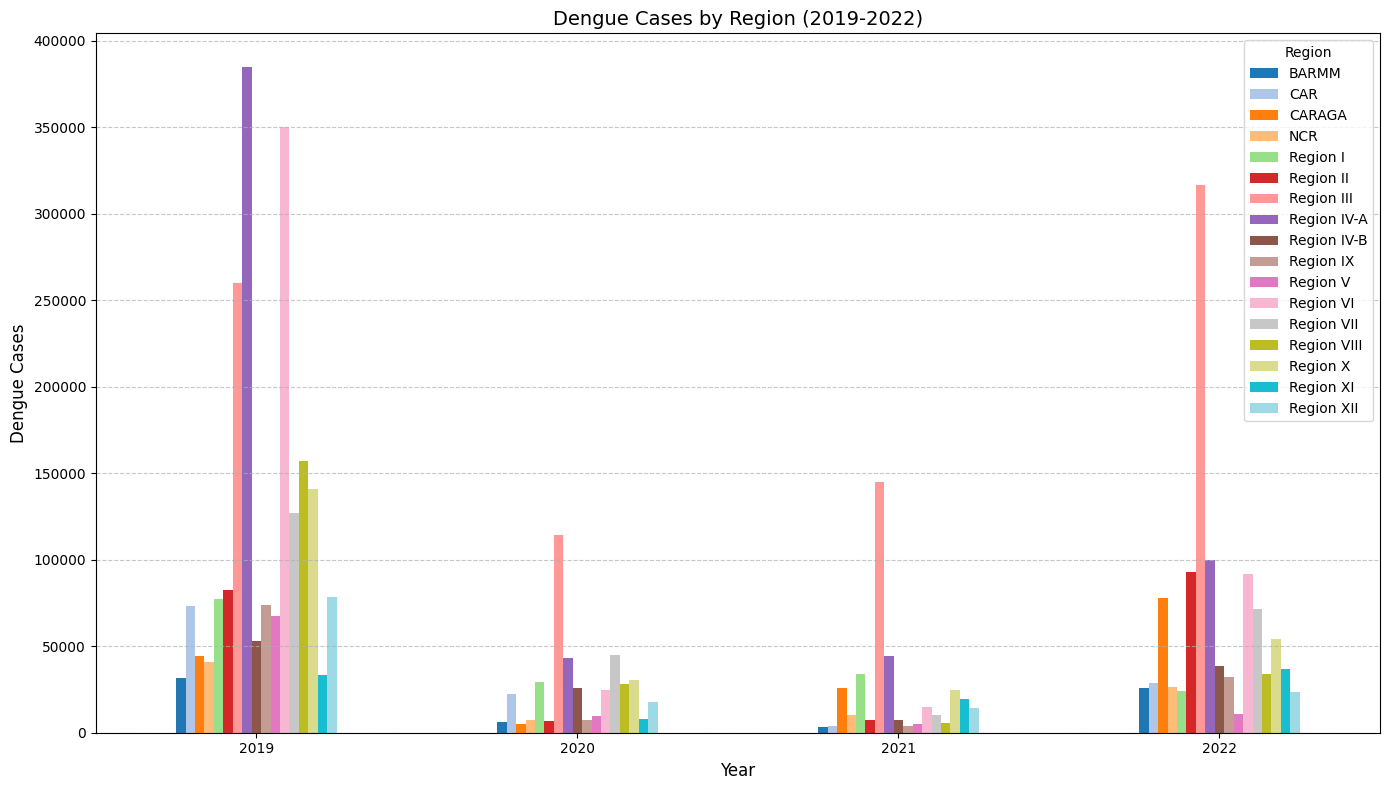

In [9]:
# Aggregate the data to ensure unique combinations of Year and Region
aggregated_data = phdataCleaned.groupby(['Year', 'Region'], as_index=False).agg({'Dengue_Cases': 'sum'})

# Convert 'Year' to integer to remove the decimal
aggregated_data['Year'] = aggregated_data['Year'].astype(int)

# Pivot the data for bar graph
pivot_data = aggregated_data.pivot(index="Year", columns="Region", values="Dengue_Cases")

# Plot the bar graph
pivot_data.plot(kind="bar", figsize=(14, 8), colormap="tab20")

# Adding labels and title
plt.xlabel("Year", fontsize=12)
plt.ylabel("Dengue Cases", fontsize=12)
plt.title("Dengue Cases by Region (2019-2022)", fontsize=14)

plt.grid(axis='y', linestyle='--', alpha=0.7)

# Customizing ticks
plt.xticks(fontsize=10, rotation=0)
plt.yticks(fontsize=10)

plt.tight_layout()

plt.show()


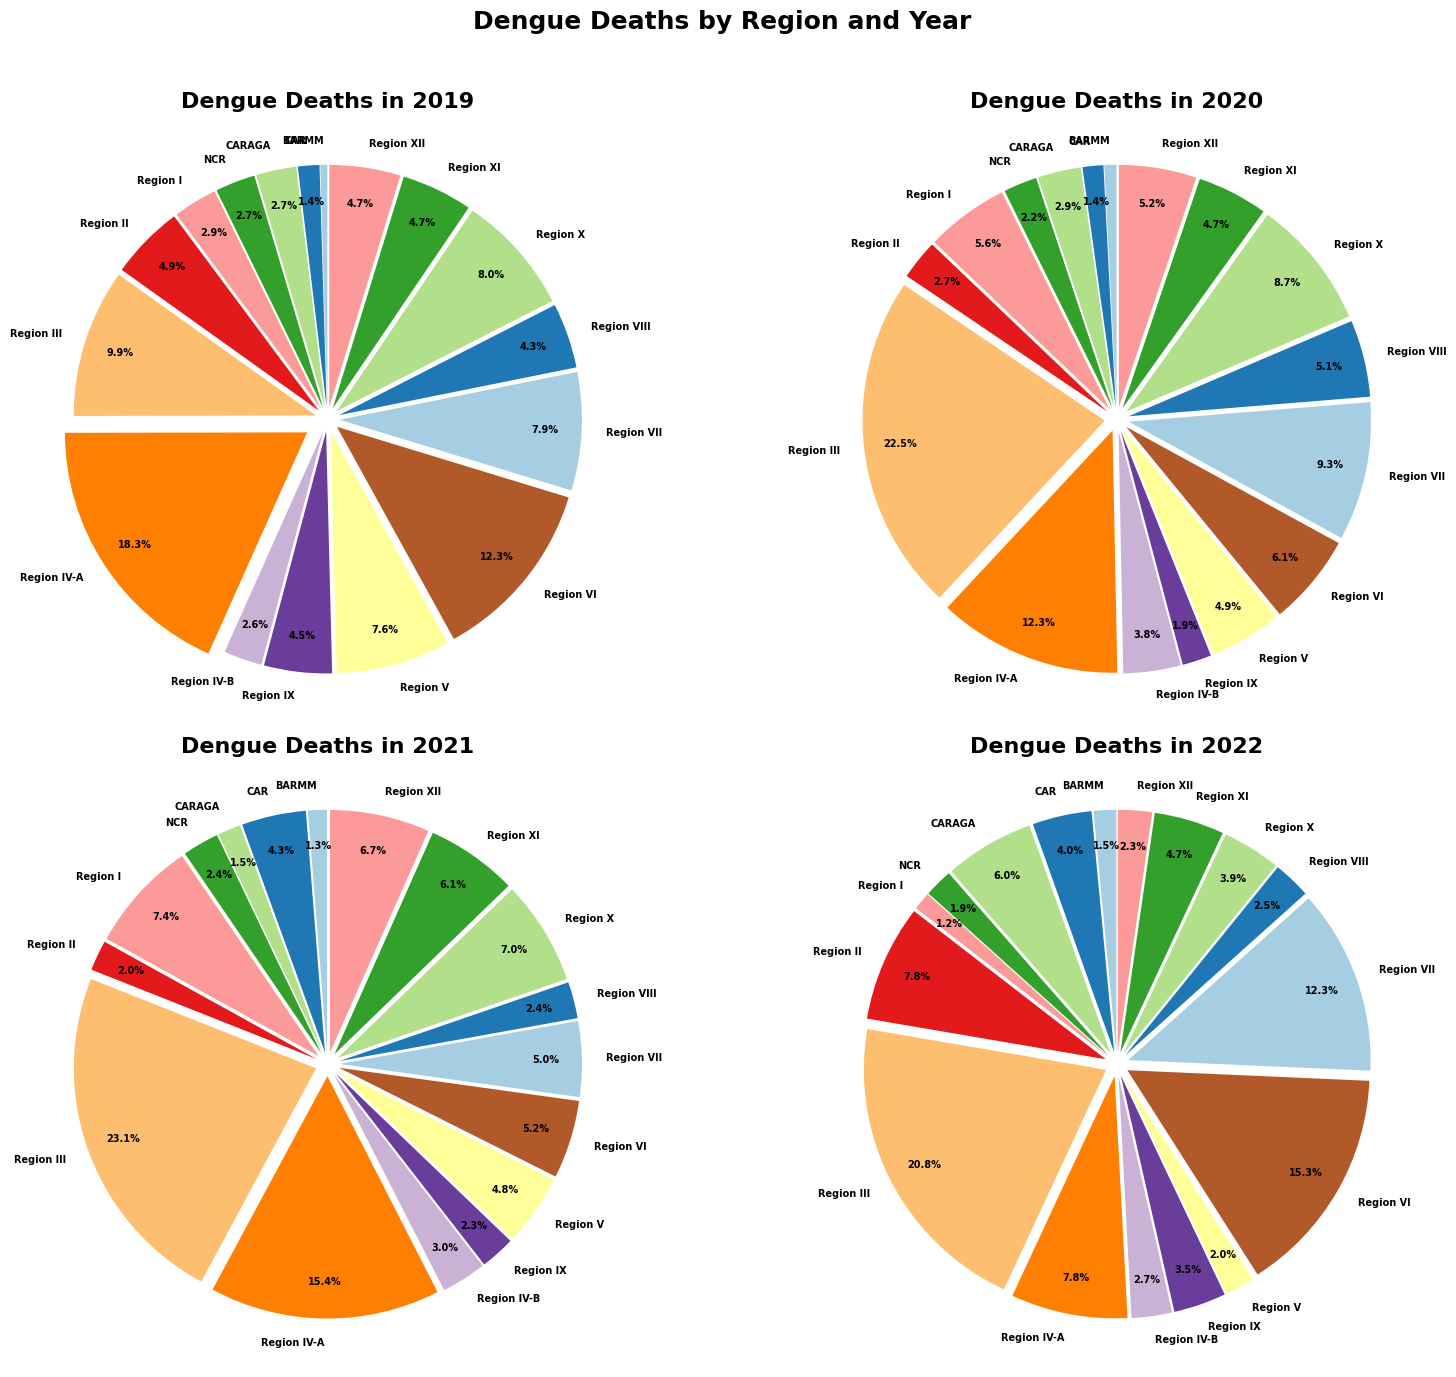

In [10]:
# Aggregate the data to ensure unique combinations of Year and Region
aggregated_data = phdataCleaned.groupby(['Year', 'Region'], as_index=False).agg({'Dengue_Deaths': 'sum'})

# Convert 'Year' to integer to remove the decimal
aggregated_data['Year'] = aggregated_data['Year'].astype(int)

# Get the unique years in the data
unique_years = aggregated_data['Year'].unique()

# Set up the subplots (4 pie charts, one for each year)
fig, axes = plt.subplots(2, 2, figsize=(16, 14))  # Increased size for better readability
fig.suptitle('Dengue Deaths by Region and Year', fontsize=18, weight='bold')  # Title for the entire figure

# Flatten the axes for easy iteration
axes = axes.flatten()

# Custom function to format the percentage, avoiding small values
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))  # Calculate the absolute value
    if pct < 1:  # Exclude labels with less than 1%
        return ''
    return f"{pct:.1f}%"  # Display percentage with 1 decimal

# Loop through each year and plot a pie chart
for i, year in enumerate(unique_years[:4]):  # Limiting to the first 4 years for 4 pie charts
    # Filter data for the specific year
    year_data = aggregated_data[aggregated_data['Year'] == year]

    # Find the index of the region with the maximum Dengue deaths
    max_death_idx = year_data['Dengue_Deaths'].idxmax()

    # Create an explode array where only the largest value is exploded
    explode = [0.1 if i == max_death_idx else 0.05 for i in range(len(year_data))]

    # Plot the pie chart with the explode effect applied to the largest value
    wedges, texts, autotexts = axes[i].pie(year_data['Dengue_Deaths'],
                                           labels=year_data['Region'],
                                           autopct=lambda pct: func(pct, year_data['Dengue_Deaths']),
                                           startangle=90,
                                           pctdistance=0.85,
                                           labeldistance=1.1,  # Adjusted label distance for better positioning
                                           explode=explode,  # Apply explode effect to the largest value
                                           colors=plt.cm.Paired.colors)  # Color map for consistency

    # Customize label and percentage fonts for a more professional appearance
    for text in texts:
        text.set_fontsize(7)  # Slightly larger font size for region labels
        text.set_fontweight('bold')  # Make region labels bold
    for autotext in autotexts:
        autotext.set_fontsize(7)  # Larger font size for percentages
        autotext.set_fontweight('bold')  # Bold percentage values

    # Title for each subplot with enhanced style
    axes[i].set_title(f'Dengue Deaths in {year}', fontsize=16, fontweight='bold')

# Adjust layout for better spacing and to avoid overlapping
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Increased space for the suptitle

# Display the plot
plt.show()


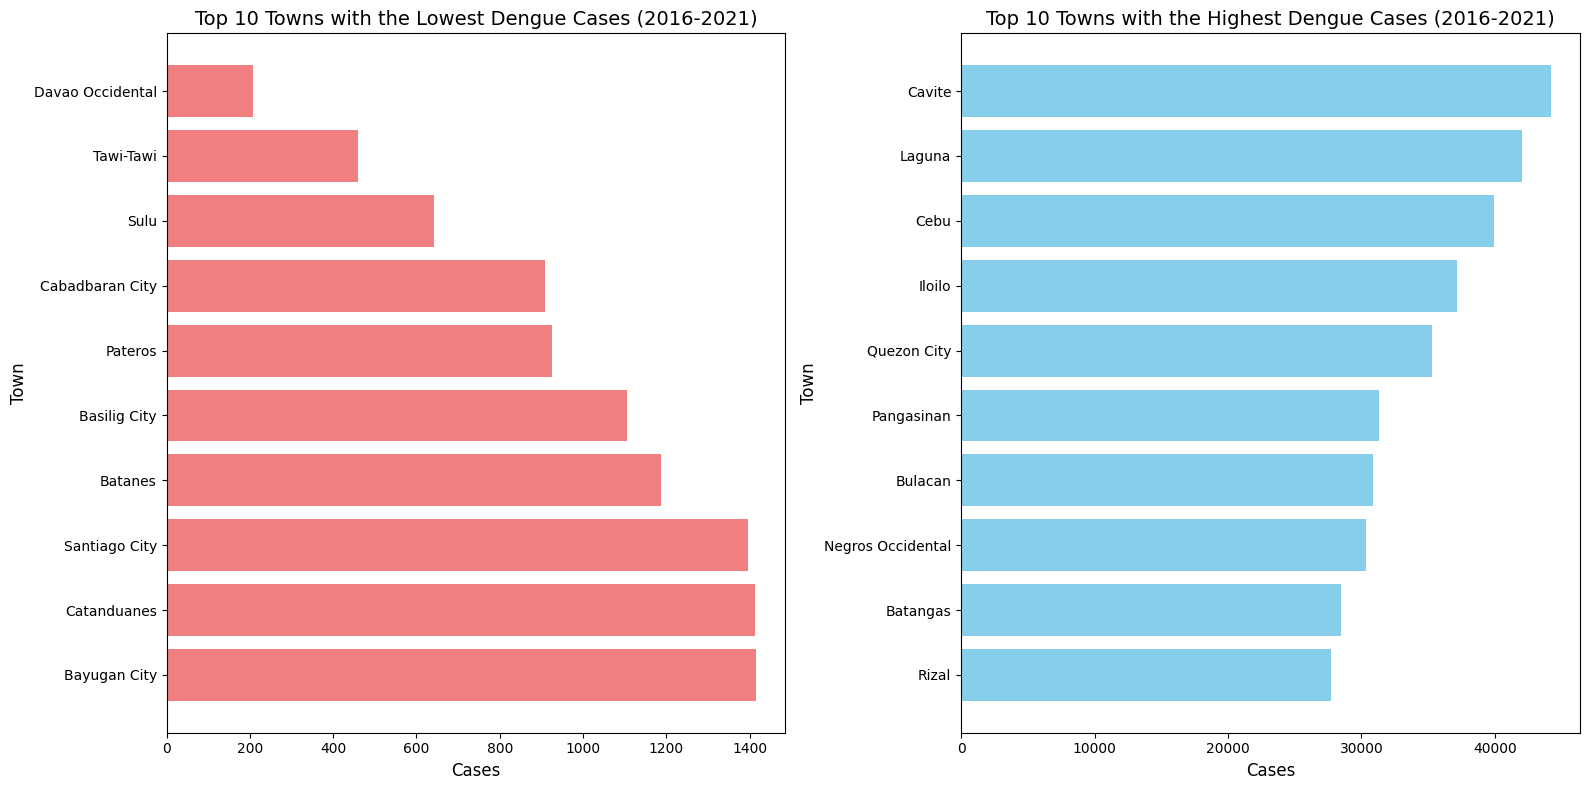

In [11]:
# Drop the columns "Date" and "Year"
townCases = townCases.drop(columns=["Date", "Year"])

# Group by unique Region and Town, summing Cases and Deaths
aggregated_townCases_df = (
    townCases.groupby(["Region", "Town"], as_index=False)
    .agg({"Cases": "sum", "Deaths": "sum"})
)

# Top 10 towns with the lowest cases across all regions
top_10_lowest = aggregated_townCases_df.nsmallest(10, "Cases")

# Top 10 towns with the highest cases across all regions
top_10_highest = aggregated_townCases_df.nlargest(10, "Cases")

# Create a figure with two horizontal bar graphs side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=False)

# Plotting the top 10 towns with the lowest cases
axes[0].barh(top_10_lowest["Town"], top_10_lowest["Cases"], color="lightcoral")
axes[0].set_title("Top 10 Towns with the Lowest Dengue Cases (2016-2021)", fontsize=14)
axes[0].set_xlabel("Cases", fontsize=12)
axes[0].set_ylabel("Town", fontsize=12)  # Label for the Y-axis on the left graph
axes[0].invert_yaxis()  # Align with the left graph
axes[0].tick_params(axis="y", labelsize=10)

# Plotting the top 10 towns with the highest cases
axes[1].barh(top_10_highest["Town"], top_10_highest["Cases"], color="skyblue")
axes[1].set_title("Top 10 Towns with the Highest Dengue Cases (2016-2021)", fontsize=14)
axes[1].set_xlabel("Cases", fontsize=12)
axes[1].set_ylabel("Town", fontsize=12)  # Label for the Y-axis on the right graph
axes[1].invert_yaxis()  # Highest cases at the top
axes[1].tick_params(axis="y", labelsize=10)

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()


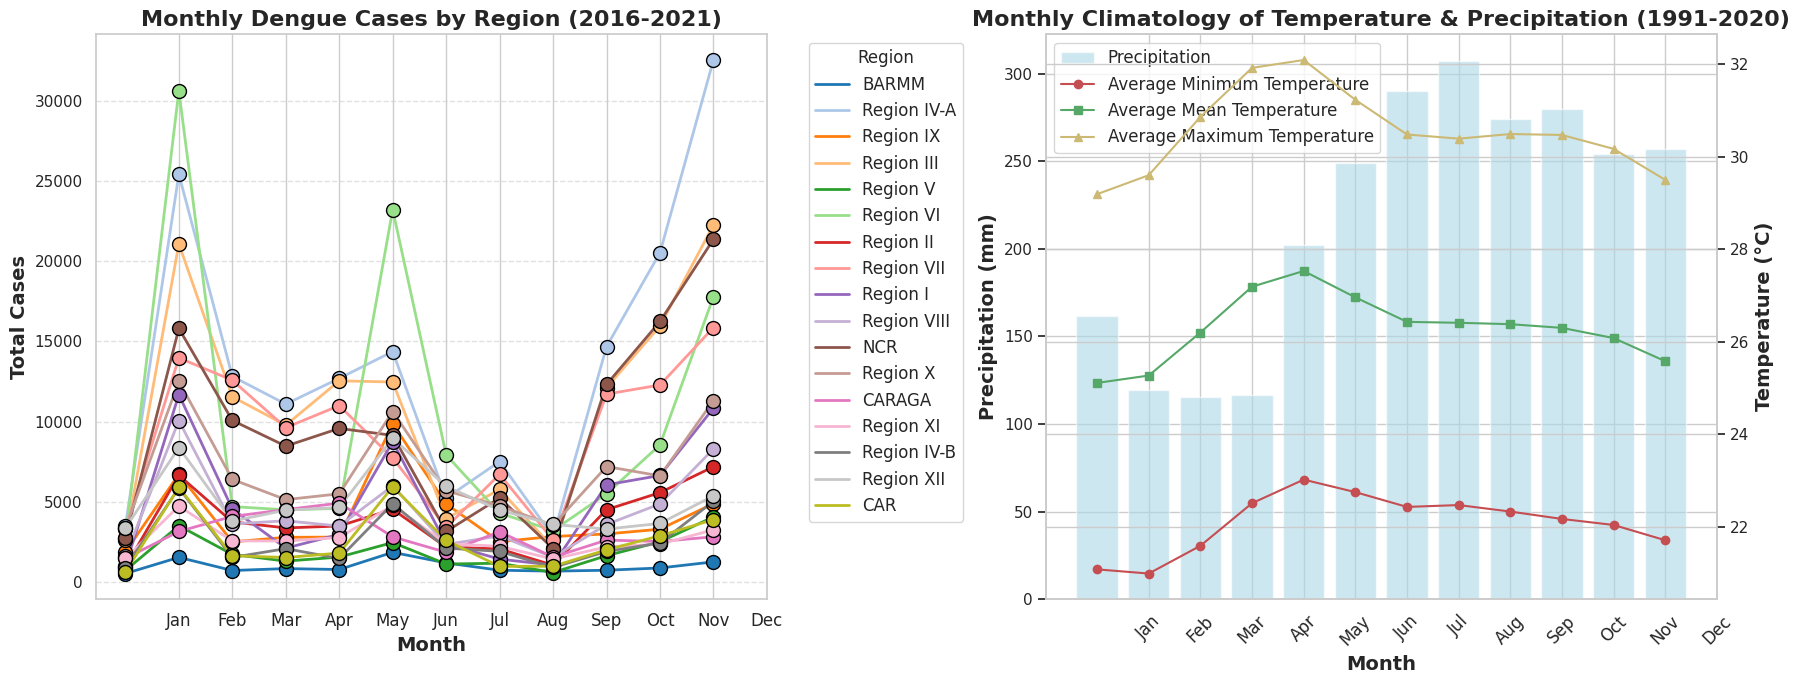

In [12]:

# Set the Seaborn style for a more professional and clean look
sns.set_theme(style="whitegrid")

# Grouping by 'Region' and 'Month', summing the 'Cases'
monthly_cases_region = townCases.groupby(["properRegion", "Month"], as_index=False)["Cases"].sum()

# Sorting the data by 'Month' to ensure months are from January to December (1 to 12)
monthly_cases_region = monthly_cases_region.sort_values(by='Month')

# Generate a color palette with enough distinct colors (using "tab20" or "Set2" for many unique colors)
colors = sns.color_palette("tab20", n_colors=len(monthly_cases_region['properRegion'].unique()))

# Create the figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Plotting the first graph (Monthly Dengue Cases by Region)
for i, region in enumerate(monthly_cases_region['properRegion'].unique()):
    region_data = monthly_cases_region[monthly_cases_region['properRegion'] == region]

    # Plot the line for the region with a distinct color
    ax1.plot(region_data['Month'], region_data['Cases'], label=region, linestyle='-', color=colors[i], linewidth=2)

    # Add scatter points to match the months exactly
    ax1.scatter(region_data['Month'], region_data['Cases'], color=colors[i], s=100, edgecolor='black', zorder=5)

# Adding labels and title to the first graph
ax1.set_xlabel('Month', fontsize=14, fontweight='bold')
ax1.set_ylabel('Total Cases', fontsize=14, fontweight='bold')
ax1.set_title('Monthly Dengue Cases by Region (2016-2021)', fontsize=16, fontweight='bold')

# Set x-axis ticks for the first graph
ax1.set_xticks(range(1, 13))
ax1.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=12)

# Add gridlines for better readability in the first graph
ax1.grid(True, which='both', axis='y', linestyle='--', alpha=0.6)

# Adding the legend for the first graph
ax1.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

# --- Second Graph: Monthly Climatology ---

# Plotting the second graph (Climate Data)
bars = ax2.bar(tempMonth['Category'], tempMonth['Precipitation'], color='lightblue', alpha=0.6, label='Precipitation')

# Creating the secondary axis for temperature
ax2_twin = ax2.twinx()

# Plotting the line graphs for the different temperature types
line_min = ax2_twin.plot(tempMonth['Category'], tempMonth['Average Minimum Surface Air Temperature'], color='r', marker='o', label='Average Minimum Temperature')
line_mean = ax2_twin.plot(tempMonth['Category'], tempMonth['Average Mean Surface Air Temperature'], color='g', marker='s', label='Average Mean Temperature')
line_max = ax2_twin.plot(tempMonth['Category'], tempMonth['Average Maximum Surface Air Temperature'], color='y', marker='^', label='Average Maximum Temperature')

# Adding labels and title to the second graph
ax2.set_xlabel('Month', fontsize=14, fontweight='bold')
ax2_twin.set_ylabel('Temperature (°C)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Precipitation (mm)', fontsize=14, fontweight='bold')
ax2.set_title('Monthly Climatology of Temperature & Precipitation (1991-2020)', fontsize=16, fontweight='bold')

# Combining the legends into one for the second graph
handles, labels = ax2.get_legend_handles_labels()
handles.extend([line_min[0], line_mean[0], line_max[0]])
labels.extend(['Average Minimum Temperature', 'Average Mean Temperature', 'Average Maximum Temperature'])
ax2.legend(handles, labels, loc='upper left', fontsize=12)

# Displaying the second graph's x-axis with rotated labels
ax2.set_xticks(range(1, 13))
ax2.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=12)
ax2.tick_params(axis='x', rotation=45)

# Tight layout to prevent overlap and make the display neat
plt.tight_layout()

# Display the plot
plt.show()


In [13]:


# Ensure required columns exist in `phdataCleaned` and drop rows with missing values
histogram_data = phdataCleaned[['regCode', 'Dengue_Cases', 'Sanitation_HH_Total', 'WaterSupply_HH_Total', 'Year']].dropna()

# Map Region Codes to Region Names for better readability
histogram_data['Region'] = histogram_data['regCode'].map(regionName)

# Define the function to plot the data based on the selected year
def plot_data(year='All'):
    # Filter data by year
    if year != 'All':
        filtered_data = histogram_data[histogram_data['Year'] == year]
    else:
        filtered_data = histogram_data

    # Group data by Region Code and calculate total Dengue Cases, Sanitation, and Water Supply
    grouped_data = filtered_data.groupby('regCode').sum().reset_index()

    # Map Region Codes to Region Names for better readability (remove unnecessary repetition)
    grouped_data['Region'] = grouped_data['regCode'].map(regionName)

    # Create the plot with 2 subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

    # Sanitation vs Dengue Cases (Bar and Line)
    ax1.bar(grouped_data['Region'], grouped_data['Dengue_Cases'], label='Dengue Cases', color='skyblue', alpha=0.8)
    ax1.plot(grouped_data['Region'], grouped_data['Sanitation_HH_Total'], label='Sanitation', color='green', marker='o', linewidth=2)
    ax1.set_title(f'Sanitation per Household (000) vs Dengue Cases per Region ({year})', fontsize=16)
    ax1.set_xlabel('Region', fontsize=12)
    ax1.set_ylabel('Total Count', fontsize=12)
    ax1.tick_params(axis='x', rotation=90)
    ax1.legend()

    # Water Supply vs Dengue Cases (Bar and Line)
    ax2.bar(grouped_data['Region'], grouped_data['Dengue_Cases'], label='Dengue Cases', color='skyblue', alpha=0.8)
    ax2.plot(grouped_data['Region'], grouped_data['WaterSupply_HH_Total'], label='Water Supply', color='orange', marker='o', linewidth=2)
    ax2.set_title(f'Water Supply Per Household (000) vs Dengue Cases per Region ({year})', fontsize=16)
    ax2.set_xlabel('Region', fontsize=12)
    ax2.set_ylabel('Total Count', fontsize=12)
    ax2.tick_params(axis='x', rotation=90)
    ax2.legend()

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

# Create a dropdown widget to select the year
year_dropdown = widgets.Dropdown(
    options=['All', 2019, 2020, 2021, 2022],
    value='All',
    description='Year:',
    disabled=False
)

# Use the interact function to update the plot based on the selected year
interact(plot_data, year=year_dropdown)


interactive(children=(Dropdown(description='Year:', options=('All', 2019, 2020, 2021, 2022), value='All'), Out…

<function __main__.plot_data(year='All')>

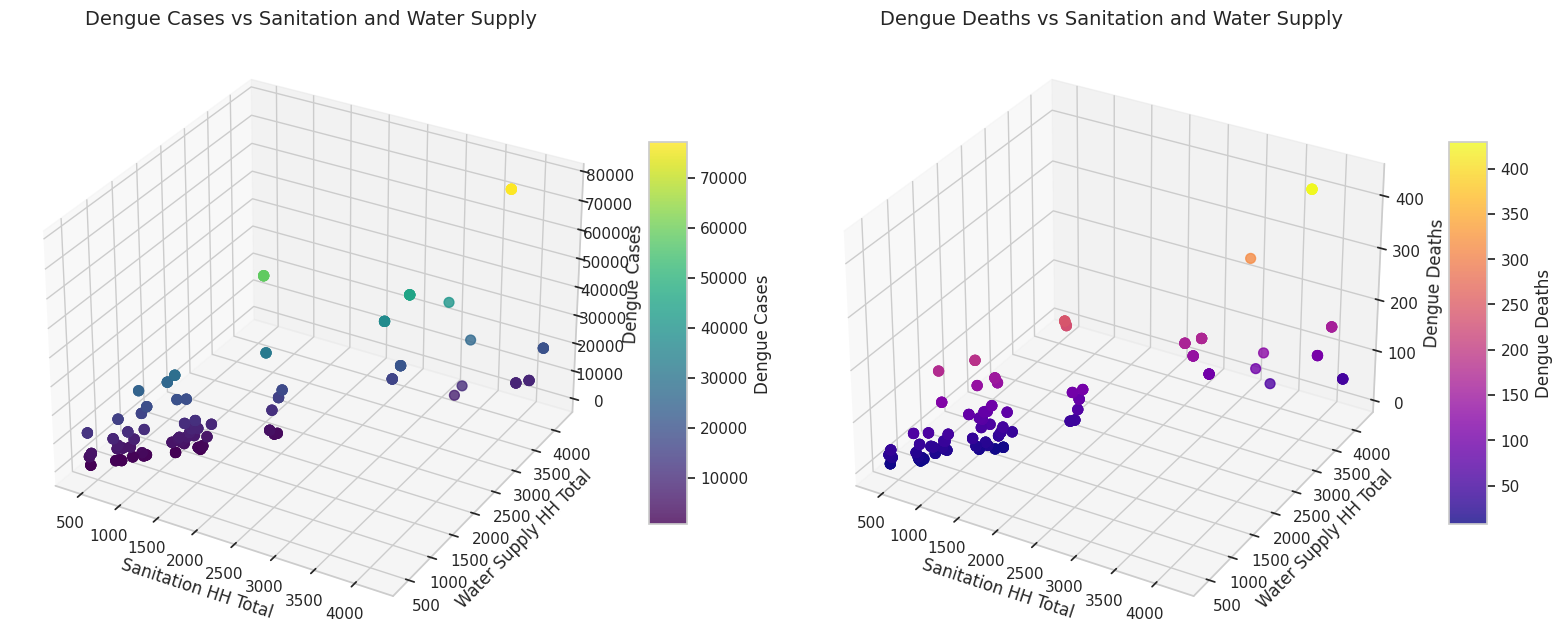

In [14]:
# Ensure required columns exist in `phdataCleaned` and drop rows with missing values
scatter_data = phdataCleaned[['Dengue_Cases', 'Dengue_Deaths', 'Sanitation_HH_Total', 'WaterSupply_HH_Total']].dropna()

# Create a figure for side-by-side 3D scatterplots
fig = plt.figure(figsize=(16, 8))

# Plot 1: Dengue Cases vs Sanitation and Water Supply
ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(
    scatter_data['Sanitation_HH_Total'],
    scatter_data['WaterSupply_HH_Total'],
    scatter_data['Dengue_Cases'],
    c=scatter_data['Dengue_Cases'],  # Color based on Dengue Cases
    cmap='viridis',
    s=50,
    alpha=0.8
)
ax1.set_title('Dengue Cases vs Sanitation and Water Supply', fontsize=14)
ax1.set_xlabel('Sanitation HH Total', fontsize=12)
ax1.set_ylabel('Water Supply HH Total', fontsize=12)
ax1.set_zlabel('Dengue Cases', fontsize=12)
color_bar1 = fig.colorbar(scatter1, ax=ax1, shrink=0.5, aspect=10)
color_bar1.set_label('Dengue Cases')

# Plot 2: Dengue Deaths vs Sanitation and Water Supply
ax2 = fig.add_subplot(122, projection='3d')
scatter2 = ax2.scatter(
    scatter_data['Sanitation_HH_Total'],
    scatter_data['WaterSupply_HH_Total'],
    scatter_data['Dengue_Deaths'],
    c=scatter_data['Dengue_Deaths'],  # Color based on Dengue Deaths
    cmap='plasma',
    s=50,
    alpha=0.8
)
ax2.set_title('Dengue Deaths vs Sanitation and Water Supply', fontsize=14)
ax2.set_xlabel('Sanitation HH Total', fontsize=12)
ax2.set_ylabel('Water Supply HH Total', fontsize=12)
ax2.set_zlabel('Dengue Deaths', fontsize=12)
color_bar2 = fig.colorbar(scatter2, ax=ax2, shrink=0.5, aspect=10)
color_bar2.set_label('Dengue Deaths')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()
